# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [1]:
# !pip install --upgrade scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
X, y

(array([[ 1.97466438,  1.61558617, -0.37040336, ...,  0.81763962,
         -0.81371692, -0.21738731],
        [ 2.76652454,  3.53432402, -1.79801762, ...,  0.98655598,
         -1.3004601 ,  0.35890156],
        [-2.56471458, -2.96290226,  0.50106052, ...,  0.31155634,
          0.55402296, -0.52836359],
        ...,
        [-0.71054065,  4.58718893, -3.17450386, ..., -3.3310495 ,
         -5.01526968,  1.39888358],
        [-3.45487124, -2.45303243,  0.24143767, ..., -0.35332958,
          1.64386913,  0.31726181],
        [-0.3476568 , -2.86971296,  2.65920138, ..., -1.70422768,
          3.34662582,  0.26659057]]),
 array([1, 1, 0, ..., 1, 0, 0]))

In [5]:
X.shape, y.shape

((10000, 10), (10000,))

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [6]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [7]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


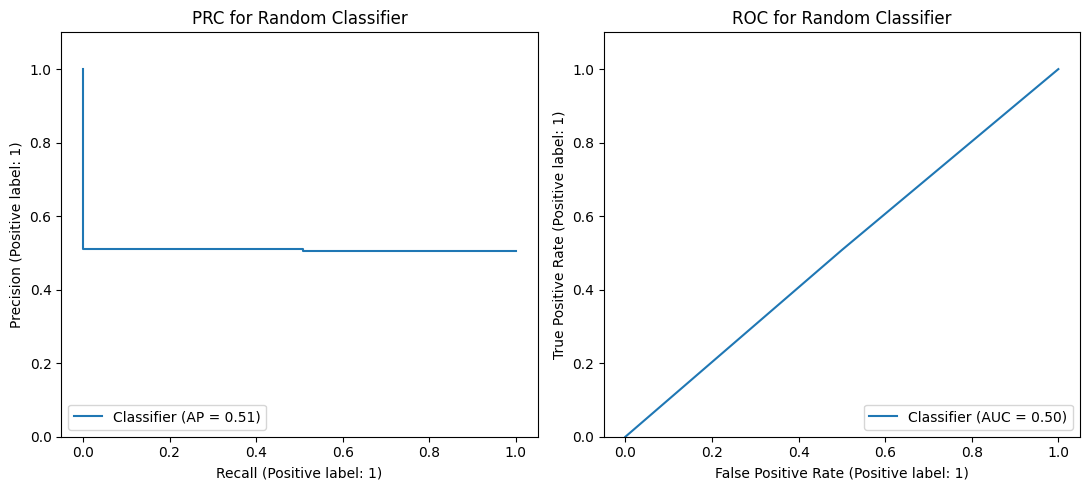

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [9]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [10]:
from sklearn.metrics import make_scorer

def auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

auc_scorer = make_scorer(
    auc_score,
    greater_is_better=True
)

In [11]:
import warnings

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

estimator = LinearSVC()
param_grid = {'C': [0.5, 1.0, 2.0, 5.0, 10.0, 50.0, 100.0]}
grid_search = GridSearchCV(estimator, param_grid, scoring=auc_scorer)

In [13]:
warnings.filterwarnings('ignore')
grid_search.fit(X_train, y_train)
warnings.filterwarnings('default')

In [14]:
df = pd.DataFrame(grid_search.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.477828,0.054073,0.003522,0.006076,0.5,{'C': 0.5},0.835801,0.823967,0.839663,0.834654,0.831737,0.833164,0.005254,2
1,0.470252,0.026361,0.006248,0.007652,1.0,{'C': 1.0},0.835801,0.823967,0.839663,0.834654,0.831737,0.833164,0.005254,2
2,0.466166,0.012890,0.002354,0.001179,2.0,{'C': 2.0},0.835801,0.827784,0.840194,0.835696,0.832107,0.834316,0.004152,1
3,0.490392,0.020364,0.000598,0.001195,5.0,{'C': 5.0},0.835630,0.829120,0.837577,0.831515,0.830693,0.832907,0.003175,4
4,0.477747,0.029948,0.003313,0.006627,10.0,{'C': 10.0},0.823985,0.827258,0.837547,0.838293,0.828807,0.831178,0.005726,5
5,0.452573,0.004279,0.006943,0.007719,50.0,{'C': 50.0},0.807908,0.818985,0.835671,0.813390,0.776024,0.810396,0.019541,6
6,0.468009,0.017074,0.002143,0.001335,100.0,{'C': 100.0},0.824655,0.694749,0.759935,0.801507,0.811560,0.778481,0.047141,7


In [15]:
grid_search.best_score_

0.8343163222212489

In [16]:
grid_search.best_params_

{'C': 2.0}

In [17]:
grid_search.scorer_

make_scorer(auc_score)

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.83187
AUC-ROC: 0.77233


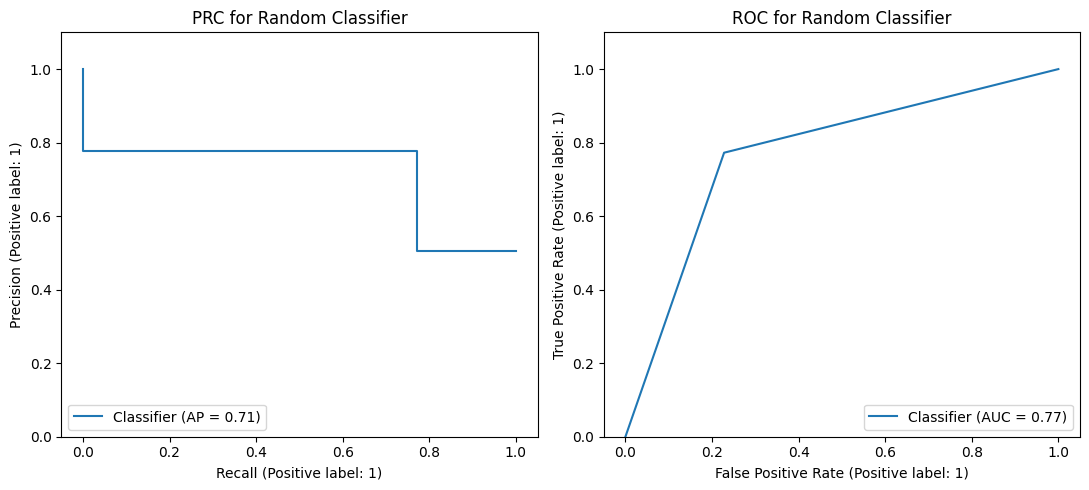

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

y_pred = grid_search.predict(X_test)

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [19]:
df_metrics.loc['LinearSVC'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_pred),
    None
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
LinearSVC,0.831868,0.772331,NaN


__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [20]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
param_grid = {'C': np.linspace(0.0001, 1, 30)}
grid_search = GridSearchCV(estimator, param_grid, scoring=auc_scorer)

grid_search.fit(X_train, y_train)

df = pd.DataFrame(grid_search.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055084,0.073408,0.002194,0.000400,0.0001,{'C': 0.0001},0.819935,0.813239,0.826566,0.825198,0.821638,0.821315,0.004688,30
1,0.018991,0.002635,0.002926,0.000645,0.034579,{'C': 0.03457931034482759},0.835347,0.825025,0.841260,0.834654,0.831737,0.833605,0.005288,29
2,0.017120,0.002282,0.004266,0.003511,0.069059,{'C': 0.06905862068965518},0.835347,0.825025,0.841260,0.834654,0.832259,0.833709,0.005256,28
3,0.019614,0.001728,0.002997,0.000631,0.103538,{'C': 0.10353793103448276},0.835865,0.825025,0.841260,0.834654,0.832259,0.833812,0.005292,1
4,0.016595,0.005728,0.001802,0.000979,0.138017,{'C': 0.13801724137931035},0.835865,0.825025,0.841260,0.834654,0.832259,0.833812,0.005292,1
5,0.016086,0.005526,0.005447,0.005887,0.172497,{'C': 0.17249655172413794},0.835865,0.825025,0.841260,0.834654,0.832259,0.833812,0.005292,1
6,0.019478,0.001913,0.002548,0.000685,0.206976,{'C': 0.2069758620689655},0.835865,0.825025,0.841260,0.834654,0.832259,0.833812,0.005292,1
7,0.028592,0.019127,0.002799,0.000748,0.241455,{'C': 0.2414551724137931},0.835865,0.825025,0.841260,0.834654,0.832259,0.833812,0.005292,1
8,0.025586,0.008581,0.002738,0.001463,0.275934,{'C': 0.2759344827586207},0.835865,0.825025,0.841260,0.834654,0.832259,0.833812,0.005292,1
9,0.018214,0.001617,0.002131,0.000254,0.310414,{'C': 0.3104137931034483},0.835865,0.825025,0.841260,0.834654,0.832259,0.833812,0.005292,1


In [21]:
print(grid_search.best_score_, grid_search.best_params_)

0.8338124399823584 {'C': 0.10353793103448276}


AUC-PR: 0.83116
AUC-ROC: 0.77134


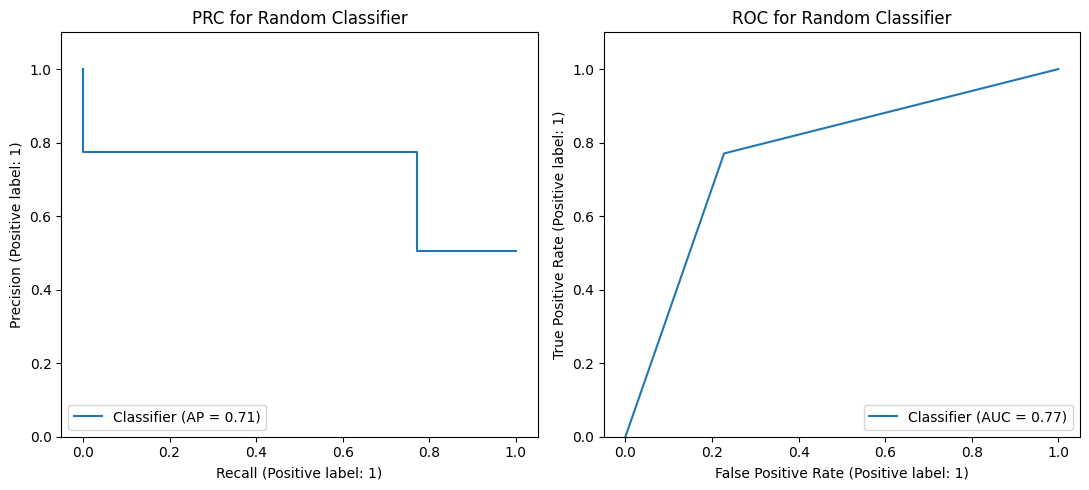

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

y_pred = grid_search.predict(X_test)

PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [23]:
df_metrics.loc['LogisticRegression'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_pred),
    None
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
LinearSVC,0.831868,0.772331,NaN
LogisticRegression,0.831157,0.771342,NaN


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: # your answer here

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [24]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

In [25]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf = clf.fit(X, y)

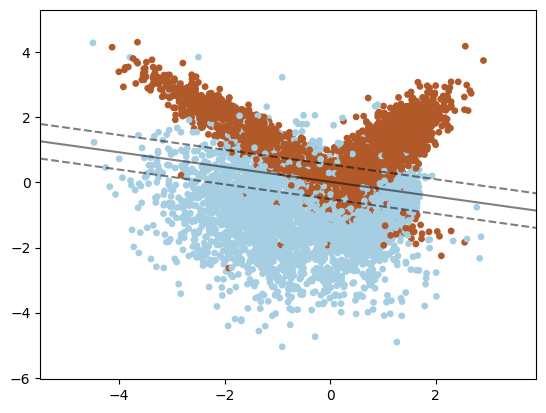

In [26]:

from sklearn.inspection import DecisionBoundaryDisplay

plt.scatter(X[:, 0], X[:, 1], c=y, s=15, cmap=plt.cm.Paired)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)

# ax.scatter(
#     clf.support_vectors_[:, 0],
#     clf.support_vectors_[:, 1],
#     s=100,
#     linewidth=1,
#     facecolors="none",
#     edgecolors="k",
# )

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [27]:
clf = LogisticRegression()
clf = clf.fit(X, y)

a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\inspection\_plot\decision_boundary.py:186: UserWarning: The following kwargs were not used by contour: 'class_of_interest'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


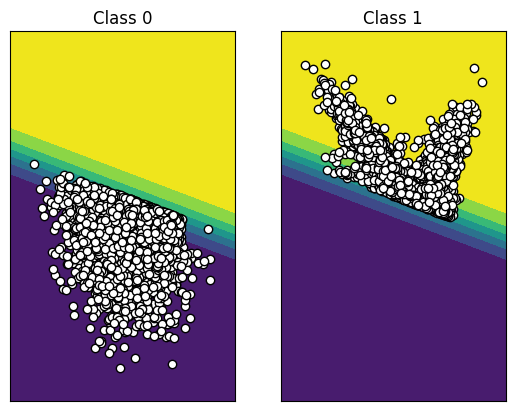

In [28]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(np.unique(y)),
)

y_pred = clf.predict(X)
for label in np.unique(y):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict_proba",
        class_of_interest=label,
        ax=axes[label],
        vmin=0,
        vmax=1,
    )
    axes[label].set_title(f"Class {label}")
    mask_y_pred = y_pred == label
    axes[label].scatter(
        X[mask_y_pred, 0], X[mask_y_pred, 1], marker="o", c="w", edgecolor="k"
    )
    axes[label].set(xticks=(), yticks=())

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [29]:
def plot_calibration_curve(y_test, preds, color, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append((np.sum(y_test[(preds > l) & (preds <= r)] == 1)) / (y_test[(preds > l) & (preds <= r)].size))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, color=color, label=label)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [30]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
from sklearn.calibration import calibration_curve

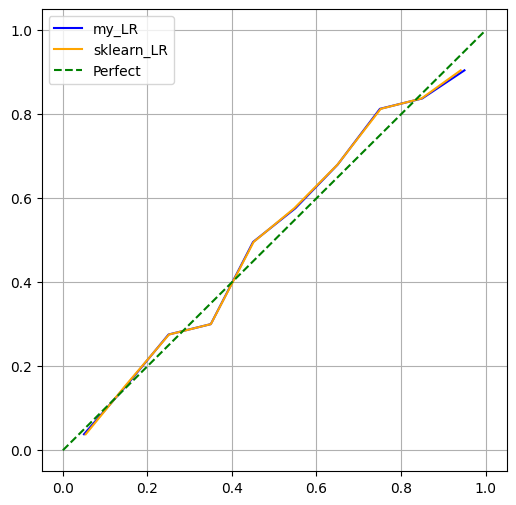

In [32]:
lr = LogisticRegression()
lr = lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, lr_pred, 'blue', 'my_LR')

lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=10)
plt.plot(lr_pred_prob, lr_true_prob, label='sklearn_LR', color='orange')

plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.legend()

a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


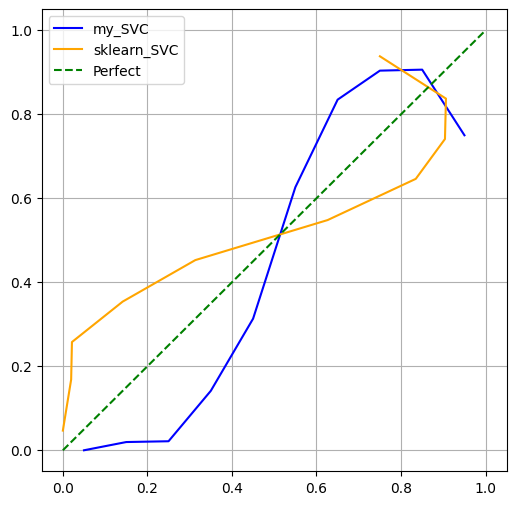

In [33]:
svc = LinearSVC()
svc = svc.fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

plot_calibration_curve(y_test, svc_pred, 'blue', 'my_SVC')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=10)
plt.plot(svc_true_prob, svc_pred_prob, label='sklearn_SVC', color='orange')

plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.legend()

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

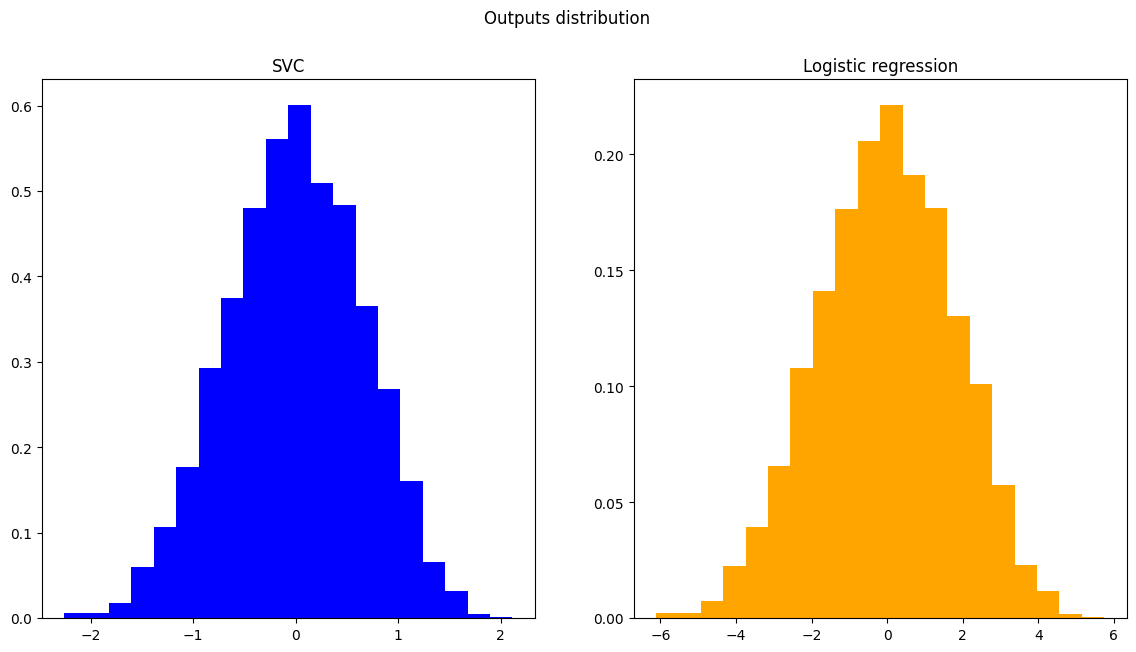

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc.decision_function(X_test), bins=20, color='blue', density='True')
axs[1].hist(lr.decision_function(X_test), bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()


Чем они различаются? Чем вы можете объяснить это?

Ответ: # your answer here

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
a:\repos\ml-course-hse\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

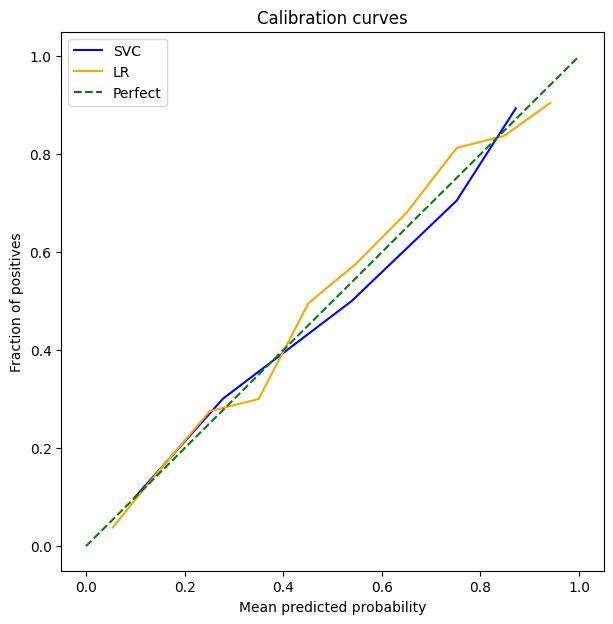

In [35]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svc = CalibratedClassifierCV(base_estimator=svc)
calibrated_svc.fit(X_train, y_train)

plt.figure(figsize=(7, 7))

svc_pred_prob_c, svc_true_prob_c = calibration_curve(y_test, calibrated_svc.predict_proba(X_test)[:, 1])

plt.plot(svc_pred_prob_c, svc_true_prob_c, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [36]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [91]:
import wget
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
filename = wget.download(url)
filename

'adult.data'

In [37]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [38]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [39]:
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [42]:
X_train.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
14004,60,State-gov,194252,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,3103,0,40,United-States
21060,41,Local-gov,26669,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
7926,18,Private,165754,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,30,United-States


In [43]:
y_train.head(3)

14004    1
21060    0
7926     0
Name: income, dtype: int32

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [45]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
categorical

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [47]:
numeric_features = list(X_train.select_dtypes([np.number]).columns)
numeric_features

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [63]:
import time
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('oe', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('oe_and_scaling', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))

In [64]:
df = pd.DataFrame(columns=["AUC-PR", "time_sec"])
df.loc["OrdinalEncoder"] = [auc(recall, precision), end - start]

In [65]:
df

,AUC-PR,time_sec
OrdinalEncoder,0.682233,0.750488


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: # your answer here

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [66]:
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=100000))
])

start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))

df.loc["OneHotEncoder"] = [auc(recall, precision), end - start]
df

,AUC-PR,time_sec
OrdinalEncoder,0.682233,0.750488
OneHotEncoder,0.767133,0.964307


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [92]:
train = X_train.copy()
train["income"] = y_train
train.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14004,60,State-gov,194252,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,3103,0,40,United-States,1
21060,41,Local-gov,26669,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,0


In [93]:
test = X_test.copy()
test["income"] = y_test
test.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
7725,53,Private,30447,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,50,United-States,0
695,25,?,202480,Assoc-acdm,12,Never-married,?,Other-relative,White,Male,0,0,45,United-States,0


In [94]:
def mean_target_encoding(data):
    for c in categorical:
        mean = data.groupby(c)['income'].mean()
        data[c] = data[c].map(mean)
    return data

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

model = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=100000))
])

start = time.time()
train = mean_target_encoding(train)
model = model.fit(train.drop(columns=['income']), train['income'])
end = time.time()

test = mean_target_encoding(test)
precision, recall, _ = precision_recall_curve(test['income'], model.decision_function(test.drop(columns=['income'])))

df.loc["MeanTargetEncoder"] = [auc(recall, precision), end - start]
df

,AUC-PR,time_sec
OrdinalEncoder,0.682233,0.750488
OneHotEncoder,0.767133,0.964307
MeanTargetEncoder,0.648893,0.110498


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [ ]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [100]:
def add_noise(data):
    for c in categorical:
        data[c] += np.random.uniform(low=-10.0, high=10.0, size=len(data[c]))
    return data

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

model = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=100000))
])

start = time.time()
train = add_noise(train)
model = model.fit(train.drop(columns=['income']), train['income'])
end = time.time()

test = add_noise(test)
precision, recall, _ = precision_recall_curve(test['income'], model.decision_function(test.drop(columns=['income'])))

df.loc["MeanTargetEncoderNoise"] = [auc(recall, precision), end - start]
df

,AUC-PR,time_sec
OrdinalEncoder,0.682233,0.750488
OneHotEncoder,0.767133,0.964307
MeanTargetEncoder,0.648893,0.110498
MeanTargetEncoderNoise,0.648893,0.068080


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [111]:
train = X_train.copy()
train["income"] = y_train

test = X_test.copy()
test["income"] = y_test

def mean_target_encoding_smooth(data, C):
    for c in categorical:
        mean = (data.groupby(c)['income'].sum() + C * data['income'].mean()) / (data.groupby(c)['income'].size() + C)
        data[c] = data[c].map(mean)
    return data

def add_noise(data):
    for c in categorical:
        data[c] += np.random.uniform(low=-10.0, high=10.0, size=len(data[c]))
    return data

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

model = Pipeline(steps=[
    ('scaling', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=100000))
])

start = time.time()
train = mean_target_encoding_smooth(train, 10)
model = model.fit(train.drop(columns=['income']), train['income'])
end = time.time()

test = mean_target_encoding_smooth(test, 10)
precision, recall, _ = precision_recall_curve(test['income'], model.decision_function(test.drop(columns=['income'])))

df.loc["MeanTargetEncoderSmooth"] = [auc(recall, precision), end - start]
df

,AUC-PR,time_sec
OrdinalEncoder,0.682233,0.750488
OneHotEncoder,0.767133,0.964307
MeanTargetEncoder,0.648893,0.110498
MeanTargetEncoderNoise,0.648893,0.068080
MeanTargetEncoderSmooth,0.648893,0.143070


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [ ]:
#your code here

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ # your answer here

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [159]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [160]:
train, test = train_test_split(df, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [161]:
train.shape

(24420, 15)

In [162]:
X_train = train.drop(columns=['income'])
y_train = train['income']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

ohe = column_transformer.fit(X_train, y_train)
# ohe.get_feature_names_out()
X_train = column_transformer.transform(X_train)
X_train.shape

(24420, 108)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [163]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)

X_test = test.drop(columns=['income'])
y_test = test['income']
X_test = column_transformer.transform(X_test)
precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test))

df = pd.DataFrame(columns=["AUC-PR"])
df.loc["lr_ohe"] = [auc(recall, precision)]
df

,AUC-PR
lr_ohe,0.767133


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
ids = np.argsort(model.coef_[0])[::-1][:40]
ids

array([105,  26,  27,  52,  36,  62,  61,  71,  70,  43,  82, 104,  45,
         1,  13,  42,  12,  90,  84,  65,  69,  44,  59,  99,  96, 107,
       102,  74,  54,   5, 101,  48, 106,  35,  23,   4,  19,  33,  98,
        57], dtype=int64)

In [156]:
X_train[0].shape

(1, 108)

In [157]:
X_train_new = X_train[:, ids]
X_train_new.shape

(24420, 40)

In [168]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train_new, y_train)

precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test[:, ids]))

df.loc["lr_ohe_40_features"] = [auc(recall, precision)]
df

,AUC-PR
lr_ohe,0.767133
lr_ohe_40_features,0.764019


Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
#your code here

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
#your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
# SequentialFeatureSelector

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
# your code here

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [ ]:
#your code here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__